<a href="https://www.kaggle.com/code/klyushnik/reviews-with?scriptVersionId=168290991" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/goodreads-books-reviews-290312/goodreads_test.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_sample_submission.csv
/kaggle/input/goodreads-books-reviews-290312/goodreads_train.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings 
import nltk
from bs4 import BeautifulSoup
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tqdm import tqdm
import re
%matplotlib inline

warnings.filterwarnings('ignore')

import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
train = pd.read_csv('../input/goodreads-books-reviews-290312/goodreads_train.csv')
test = pd.read_csv('../input/goodreads-books-reviews-290312/goodreads_test.csv')

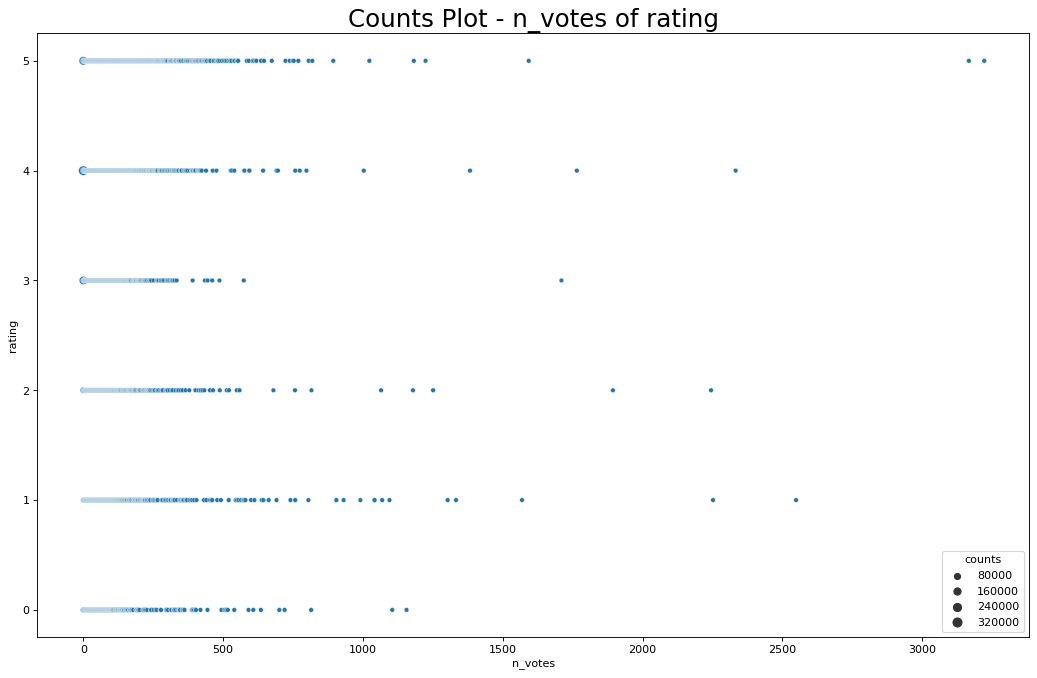

In [4]:
df_counts = train.groupby(['rating', 'n_votes']).size().reset_index(name='counts')

# Draw Stripplot
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)    
sns.scatterplot(df_counts.n_votes, df_counts.rating, size=df_counts.counts*2, ax=ax)

# Decorations
plt.title('Counts Plot - n_votes of rating', fontsize=22)
plt.show()

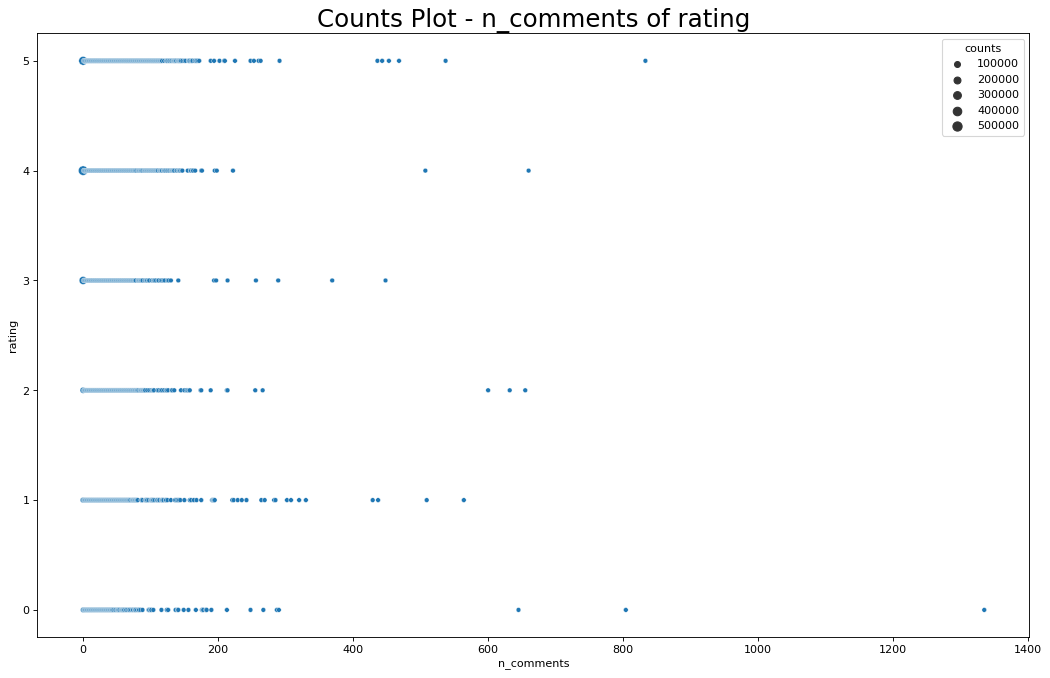

In [5]:
df_counts = train.groupby(['rating', 'n_comments']).size().reset_index(name='counts')

# Draw Stripplot
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)    
sns.scatterplot(df_counts.n_comments, df_counts.rating, size=df_counts.counts*2, ax=ax)

# Decorations
plt.title('Counts Plot - n_comments of rating', fontsize=22)
plt.show()

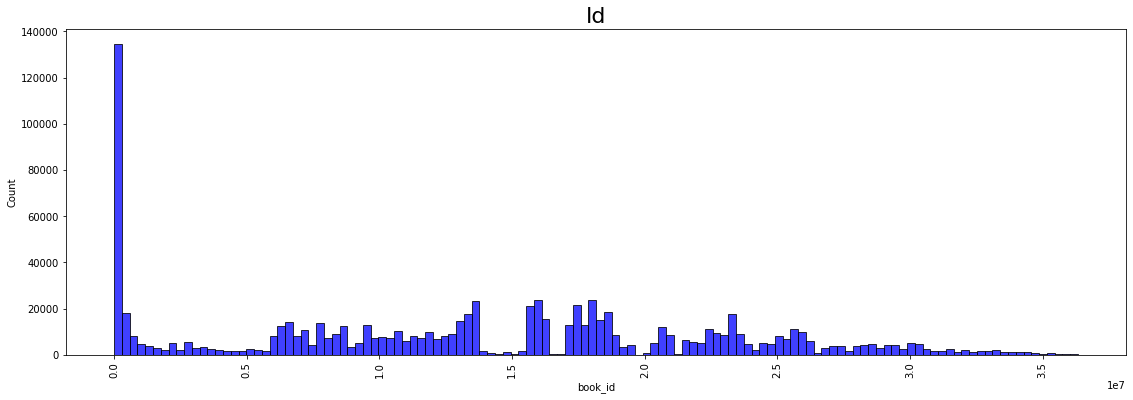

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(19, 6))
sns.histplot(x='book_id', data=train, palette='Paired', ax=ax, color = 'blue')
ax.tick_params(axis='x', rotation=90)
plt.title("Id", fontsize=22)
plt.show()

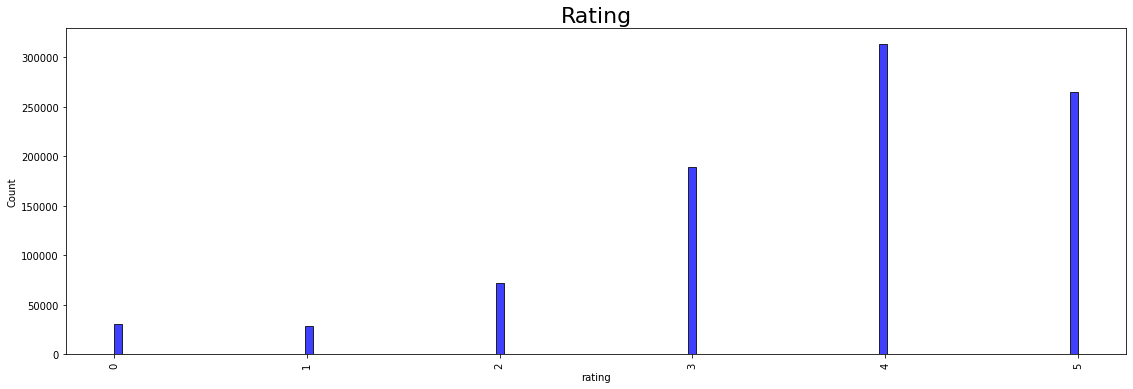

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(19, 6))
sns.histplot(x='rating', data=train, palette='Paired', ax=ax, color = 'blue')
ax.tick_params(axis='x', rotation=90)
plt.title("Rating", fontsize=22)
plt.show()

In [8]:
stopwords = stopwords.words('english')

In [9]:
def preprocess_desc(text_col):
    preprocessed_descs = []
    url_pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tag_pattern = re.compile('@(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    for sentence in tqdm(text_col.values):
        if sentence is np.nan:
            preprocessed_descs.append(sent.lower().strip())
            continue
        else:
            sent = url_pattern.sub('', sentence)
            sent = tag_pattern.sub('', sent)
            sent = sent.replace('\\r', ' ')
            sent = sent.replace('\\"', ' ')
            sent = sent.replace('\\n', ' ')
            sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
            sent = ' '.join(e for e in sent.split() if e not in stopwords)
            preprocessed_descs.append(sent.lower().strip())
    return preprocessed_descs

In [10]:
train = train.assign(pre_text = preprocess_desc(train['review_text']))

100%|██████████| 900000/900000 [08:13<00:00, 1822.38it/s]


In [11]:
test = test.assign(pre_text = preprocess_desc(test['review_text']))

100%|██████████| 478033/478033 [04:23<00:00, 1814.18it/s]


In [12]:
train = train.drop(train[["user_id", "book_id", "review_id", "date_added", "date_updated", "read_at", "started_at", 'n_votes', 'n_comments']], axis = 1)
test = test.drop(test[["user_id", "book_id", "review_id", "date_added", "date_updated", "read_at", "started_at", 'n_votes', 'n_comments']], axis = 1)

In [13]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization,  AveragePooling1D,Flatten, GRU
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
%matplotlib inline

In [14]:
MAX_NB_WORDS = 30000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train['pre_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 288170 unique tokens.


In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(train['pre_text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (900000, 250)


In [16]:
from tensorflow.keras.utils import to_categorical

Y = to_categorical(train['rating'].values)
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (900000, 6)


In [17]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    strategy = tf.distribute.experimental.TPUStrategy
except ValueError:
    strategy = tf.distribute.get_strategy() 
    print('Number of replicas:', strategy.num_replicas_in_sync) 

Number of replicas: 1


In [18]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU")
    
if tpu:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu,) 
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy() 
    print('Running on single GPU ', gpus[0].name)
else:
    strategy = tf.distribute.get_strategy() 
    print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(810000, 250) (810000, 6)
(90000, 250) (90000, 6)


In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Embedding, GlobalMaxPooling1D, Flatten, BatchNormalization, Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# build model
with strategy.scope():
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS + 1, 50, input_length = MAX_SEQUENCE_LENGTH))

    model.add(Conv1D(64, 3, activation = 'relu', padding = 'same'))
    model.add(Conv1D(64, 3, activation = 'relu', padding = 'same'))
    model.add(MaxPooling1D(2))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(Conv1D(128, 5, activation = 'relu', padding = 'same'))
    model.add(Conv1D(128, 5, activation = 'relu', padding = 'same'))
    model.add(MaxPooling1D(3))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(Conv1D(256, 5, activation = 'relu', padding = 'same'))
    model.add(Conv1D(256, 5, activation = 'relu', padding = 'same'))
    model.add(MaxPooling1D(3))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Dropout(0.2))

    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6, activation = 'softmax'))

    model.compile(Adam(learning_rate = 1e-4),
                  loss = 'categorical_crossentropy', 
                  metrics=['accuracy'],
                  steps_per_execution = 200)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 50)           1500050   
_________________________________________________________________
conv1d (Conv1D)              (None, 250, 64)           9664      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 64)           12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 125, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 125, 64)           24832     
_________________________________________________________________
dropout (Dropout)            (None, 125, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 125, 128)          4

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(patience = 4, restore_best_weights = True, verbose = 1) # val_loss
reduce_lr = ReduceLROnPlateau(factor = 0.1, patience = 2, mode = 'min', verbose = 1) # val_loss

In [22]:
history = model.fit(X_train, 
                    Y_train, 
                    batch_size = 32 * strategy.num_replicas_in_sync,
                    epochs = 15,
                    verbose = 1,
                    validation_data = (X_test, Y_test),
                    callbacks = [reduce_lr, early_stop])

Epoch 1/15
25313/25313 [==============================] - 566s 22ms/step - loss: 1.1314 - accuracy: 0.5128 - val_loss: 1.0202 - val_accuracy: 0.5677
Epoch 2/15
25313/25313 [==============================] - 545s 22ms/step - loss: 0.9921 - accuracy: 0.5803 - val_loss: 0.9808 - val_accuracy: 0.5835
Epoch 3/15
25313/25313 [==============================] - 544s 21ms/step - loss: 0.9443 - accuracy: 0.6036 - val_loss: 0.9757 - val_accuracy: 0.5875
Epoch 4/15
25313/25313 [==============================] - 548s 22ms/step - loss: 0.9026 - accuracy: 0.6242 - val_loss: 0.9695 - val_accuracy: 0.5891
Epoch 5/15
25313/25313 [==============================] - 549s 22ms/step - loss: 0.8604 - accuracy: 0.6462 - val_loss: 0.9735 - val_accuracy: 0.5885
Epoch 6/15
25313/25313 [==============================] - 552s 22ms/step - loss: 0.8173 - accuracy: 0.6692 - val_loss: 0.9967 - val_accuracy: 0.5792

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 7/15
25313/25313 [=

In [23]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2813/2813 [==============================] - 23s 8ms/step - loss: 0.9695 - accuracy: 0.5891
Test set
  Loss: 0.970
  Accuracy: 0.589


In [24]:
seq = tokenizer.texts_to_sequences(test.pre_text)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)

In [25]:
submission = pd.read_csv('/kaggle/input/goodreads-books-reviews-290312/goodreads_sample_submission.csv')

In [26]:
submission.head()

,review_id,rating
0,5c4df7e70e9b438c761f07a4620ccb7c,0
1,8eaeaf13213eeb16ad879a2a2591bbe5,0
2,dce649b733c153ba5363a0413cac988f,0
3,8a46df0bb997269d6834f9437a4b0a77,0
4,d11d3091e22f1cf3cb865598de197599,0


In [27]:
submission['rating'] = [np.argmax(i) for i in pred]

In [28]:
submission.head()

,review_id,rating
0,5c4df7e70e9b438c761f07a4620ccb7c,4
1,8eaeaf13213eeb16ad879a2a2591bbe5,4
2,dce649b733c153ba5363a0413cac988f,5
3,8a46df0bb997269d6834f9437a4b0a77,4
4,d11d3091e22f1cf3cb865598de197599,4


In [29]:
submission.to_csv('submission.csv', index = False)